#### Load Packages and Data

In [48]:
import re
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression

dodgers = pd.read_csv("dodgers-2022.csv")
row_count,column_count = dodgers.shape
print("There are {} rows and {} columns. Here is a sample:".format(
    row_count, column_count))
dodgers.head()

There are 81 rows and 12 columns. Here is a sample:


,month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead
0,APR,10,56000,Tuesday,Pirates,67,Clear,Day,NO,NO,NO,NO
1,APR,11,29729,Wednesday,Pirates,58,Cloudy,Night,NO,NO,NO,NO
2,APR,12,28328,Thursday,Pirates,57,Cloudy,Night,NO,NO,NO,NO
3,APR,13,31601,Friday,Padres,54,Cloudy,Night,NO,NO,YES,NO
4,APR,14,46549,Saturday,Padres,57,Cloudy,Night,NO,NO,NO,NO


Minimum Attendence:  24312  Maximum Attendence:  56000  Min Percentage: 43.41%


<Axes: title={'center': 'Histogram of Attendance'}, ylabel='Frequency'>

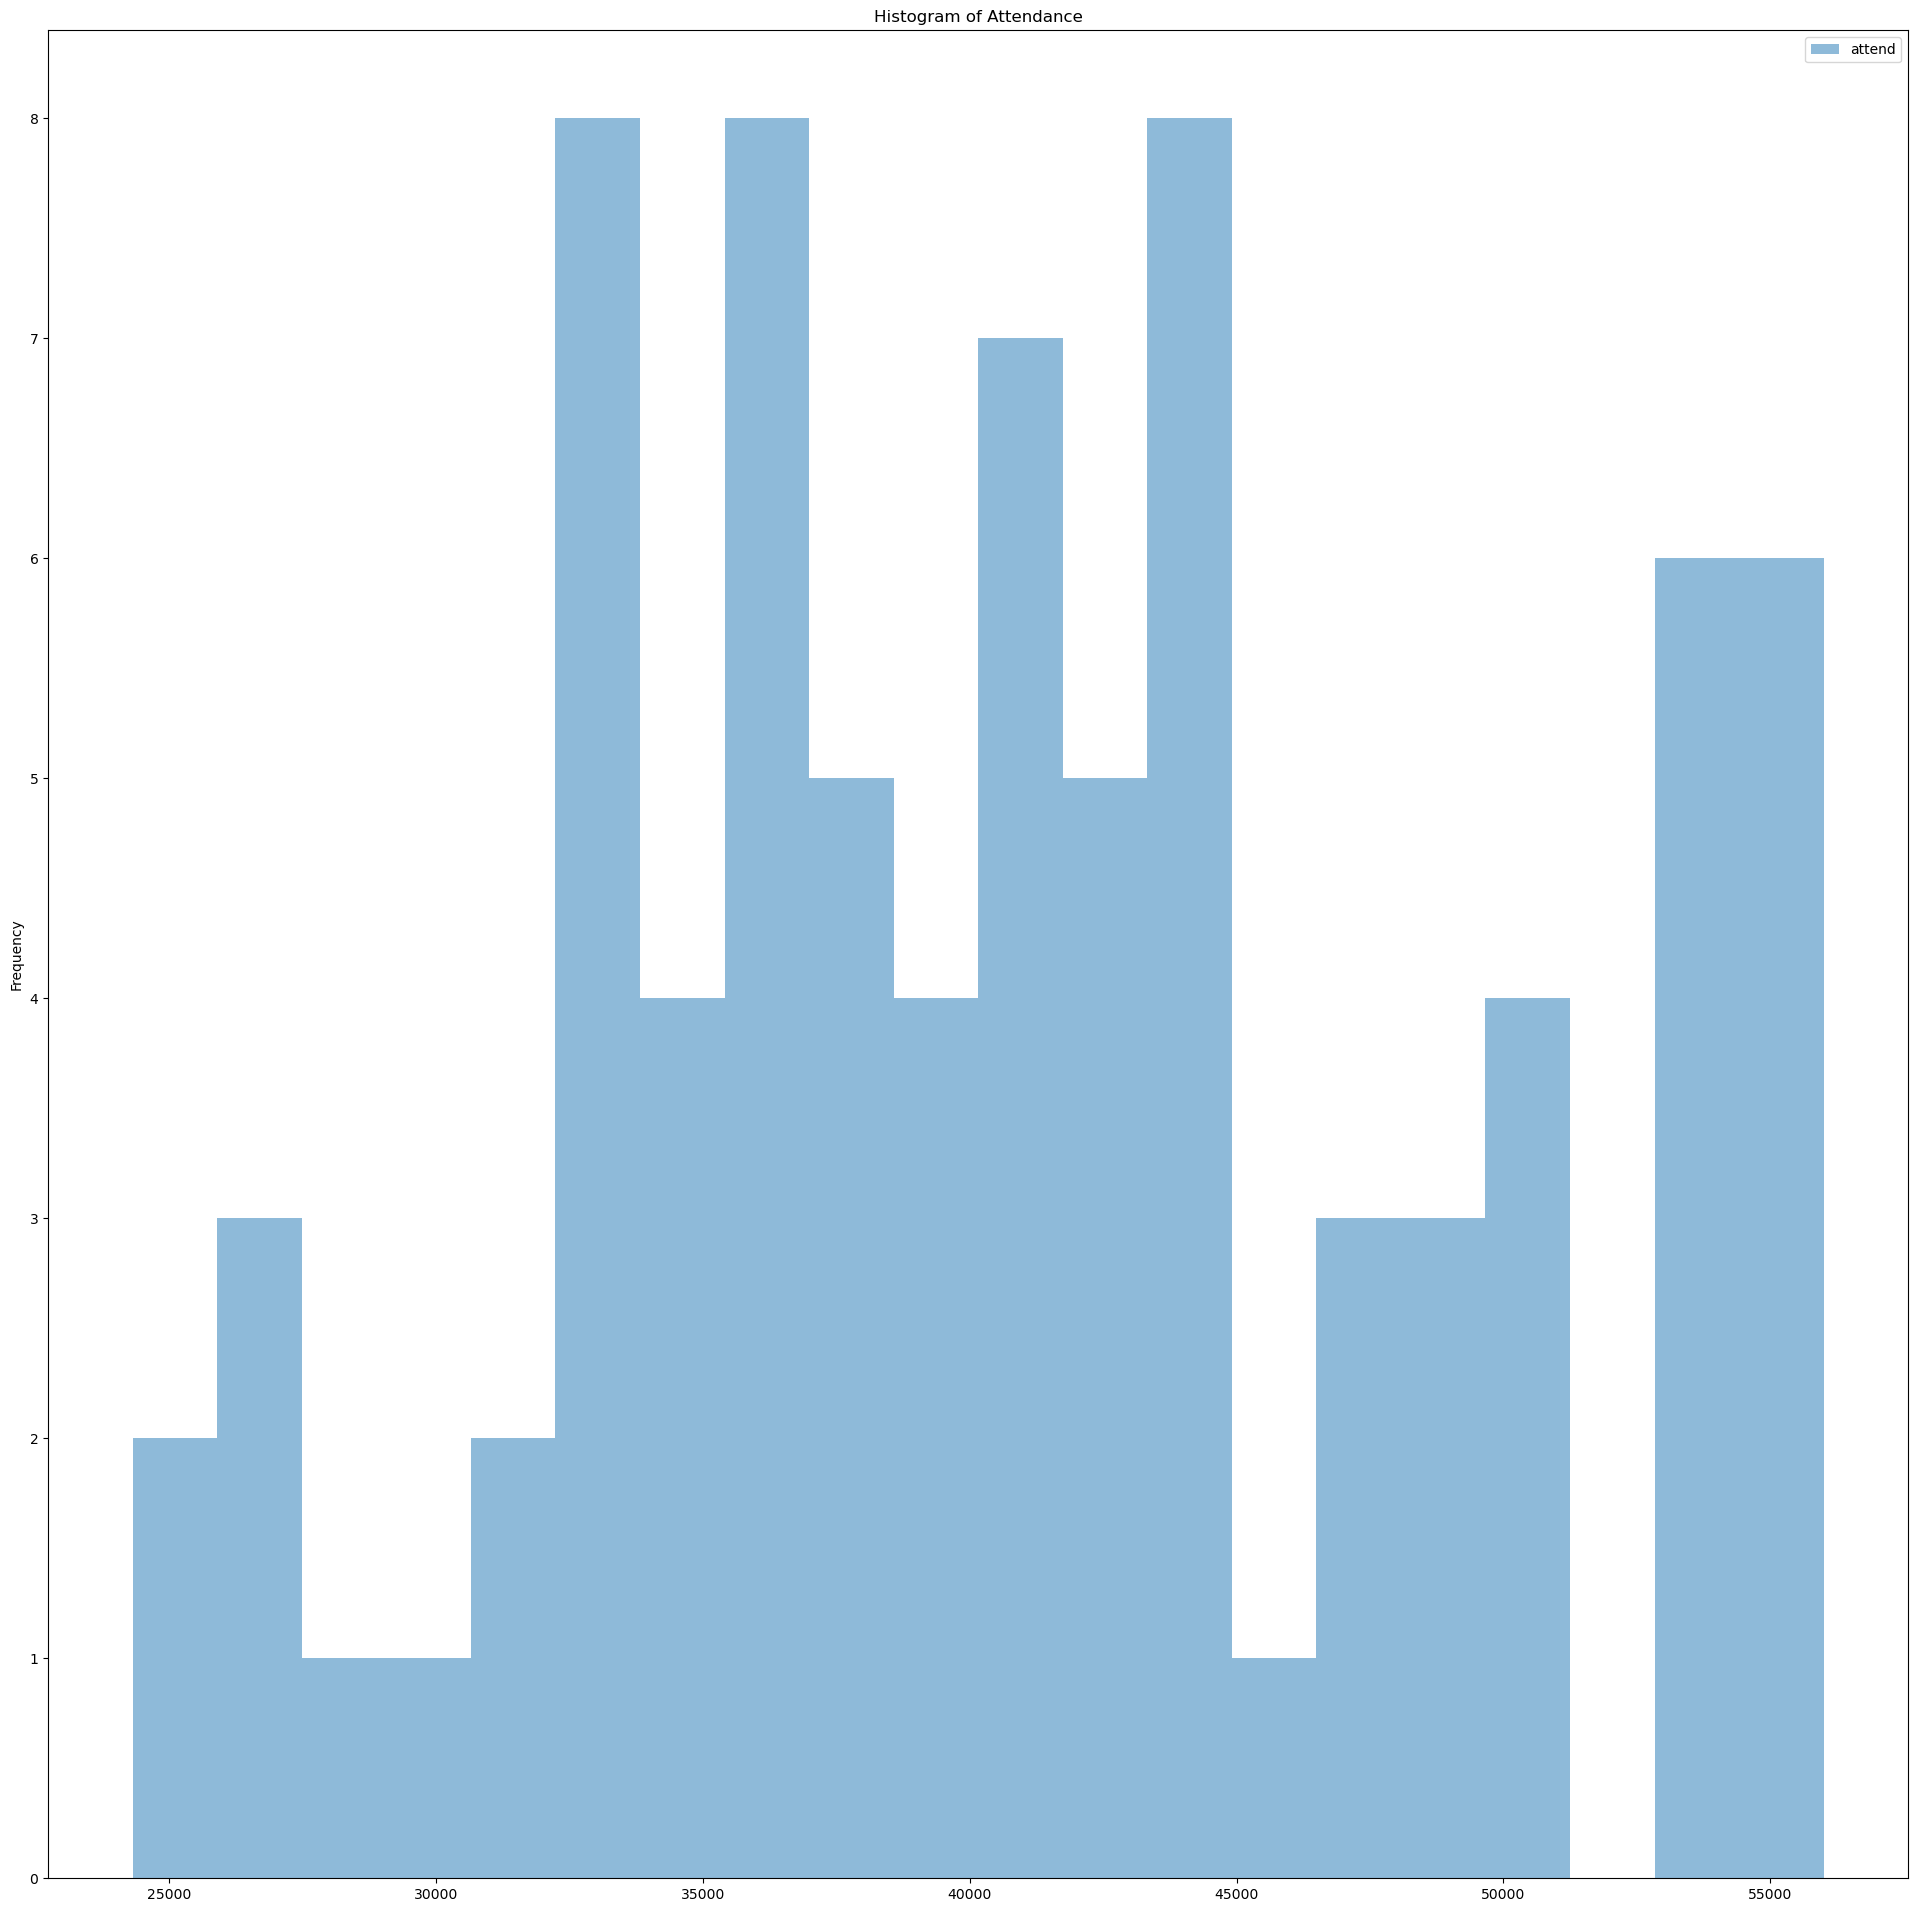

In [49]:
attend = dodgers[['attend']]
min_attend = attend.min().iloc[0]
max_attend = attend.max().iloc[0]
print("Minimum Attendence: ",min_attend," Maximum Attendence: ",max_attend," Min Percentage: {:.2f}%".format(min_attend/max_attend*100))
# Use bins that show bars for each possible value.
#bins = np.array([-.25,0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75])
attend.plot.hist(bins=20,alpha=0.5,title="Histogram of Attendance")

#### Analysis of Attendance Histogram

The Dodgers stadium looks like it has a seating capacity of 56k. Quite a few games maxed out the stadium. The stadium was always more than 43.41% full. If you exclude the games that maxed out the stadium, the remainder is close to a standard distribution with quite a bit of variability.

#### Check for Unique Values

In [50]:
for column in dodgers.columns:
    unique_values = dodgers[column].unique()
    count_unique = len(unique_values)
    if count_unique < 10:
        print("{}: {}".format(column,unique_values))
    else:
        print("{} has {} unique values".format(column,count_unique))

month: ['APR' 'MAY' 'JUN' 'JUL' 'AUG' 'SEP' 'OCT']
day has 31 unique values
attend has 80 unique values
day_of_week: ['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday']
opponent has 17 unique values
temp has 32 unique values
skies: ['Clear ' 'Cloudy']
day_night: ['Day' 'Night']
cap: ['NO' 'YES']
shirt: ['NO' 'YES']
fireworks: ['NO' 'YES']
bobblehead: ['NO' 'YES']


#### Convert Categorical Columns into Dummy Columns

In [52]:
def safe_column(input):
    result = str(input).strip()
    result = result.lower()

    # convert special characters and whitespace to "_"
    result = re.sub(r"[^a-z0-9_]", "_", result)

    # reduce adjacent "_" characters
    result = re.sub(r"_+", "_", result) 
    
    result = re.sub(r"^_", "", result) # remove leading "_"
    result = re.sub(r"_$", "", result) # remove trailing "_"
    if not result:
        result = "none"
    return result
    
# Turn categorical columns into dummy columns.
def make_dummies(df,column):
    dummies = pd.get_dummies(df[column]).rename( \
        columns=lambda x: column + '_' + safe_column(x))
    df = pd.concat([df, dummies], axis=1)
    df.drop([column], inplace=True, axis=1)
    return df

with_dummies = dodgers.copy()
categorical = [
'month',
'day_of_week',
'opponent',
]
print("Shape before creating dummy columns: ",with_dummies.shape)
for column in categorical:
    with_dummies = make_dummies(with_dummies,column)
    print("Shape after converting "+column+" into dummy columns:", \
          with_dummies.shape)

Shape before creating dummy columns:  (81, 12)
Shape after converting month into dummy columns: (81, 18)
Shape after converting day_of_week into dummy columns: (81, 24)
Shape after converting opponent into dummy columns: (81, 40)


#### Convert Boolean Columns into Integers

In [53]:
# Handle boolean columns.
with_dummies = with_dummies.rename(columns={
    'day_night': 'day_game',
    'skies':'clear_skies'
})
with_dummies['day_game'] = with_dummies['day_game'].map({
    'Day':'YES',
    'Night':'NO',
})
with_dummies['clear_skies'] = with_dummies['clear_skies'].map({
    'Clear ':'YES',
    'Cloudy':'NO',
})
with_dummies = with_dummies.replace({
    'YES':1,
    'NO':0
})

with_dummies.head()

,day,attend,temp,clear_skies,day_game,cap,shirt,fireworks,bobblehead,month_apr,...,opponent_marlins,opponent_mets,opponent_nationals,opponent_padres,opponent_phillies,opponent_pirates,opponent_reds,opponent_rockies,opponent_snakes,opponent_white_sox
0,10,56000,67,1,1,0,0,0,0,True,...,False,False,False,False,False,True,False,False,False,False
1,11,29729,58,0,0,0,0,0,0,True,...,False,False,False,False,False,True,False,False,False,False
2,12,28328,57,0,0,0,0,0,0,True,...,False,False,False,False,False,True,False,False,False,False
3,13,31601,54,0,0,0,0,1,0,True,...,False,False,False,True,False,False,False,False,False,False
4,14,46549,57,0,0,0,0,0,0,True,...,False,False,False,True,False,False,False,False,False,False


#### Check for Correlations

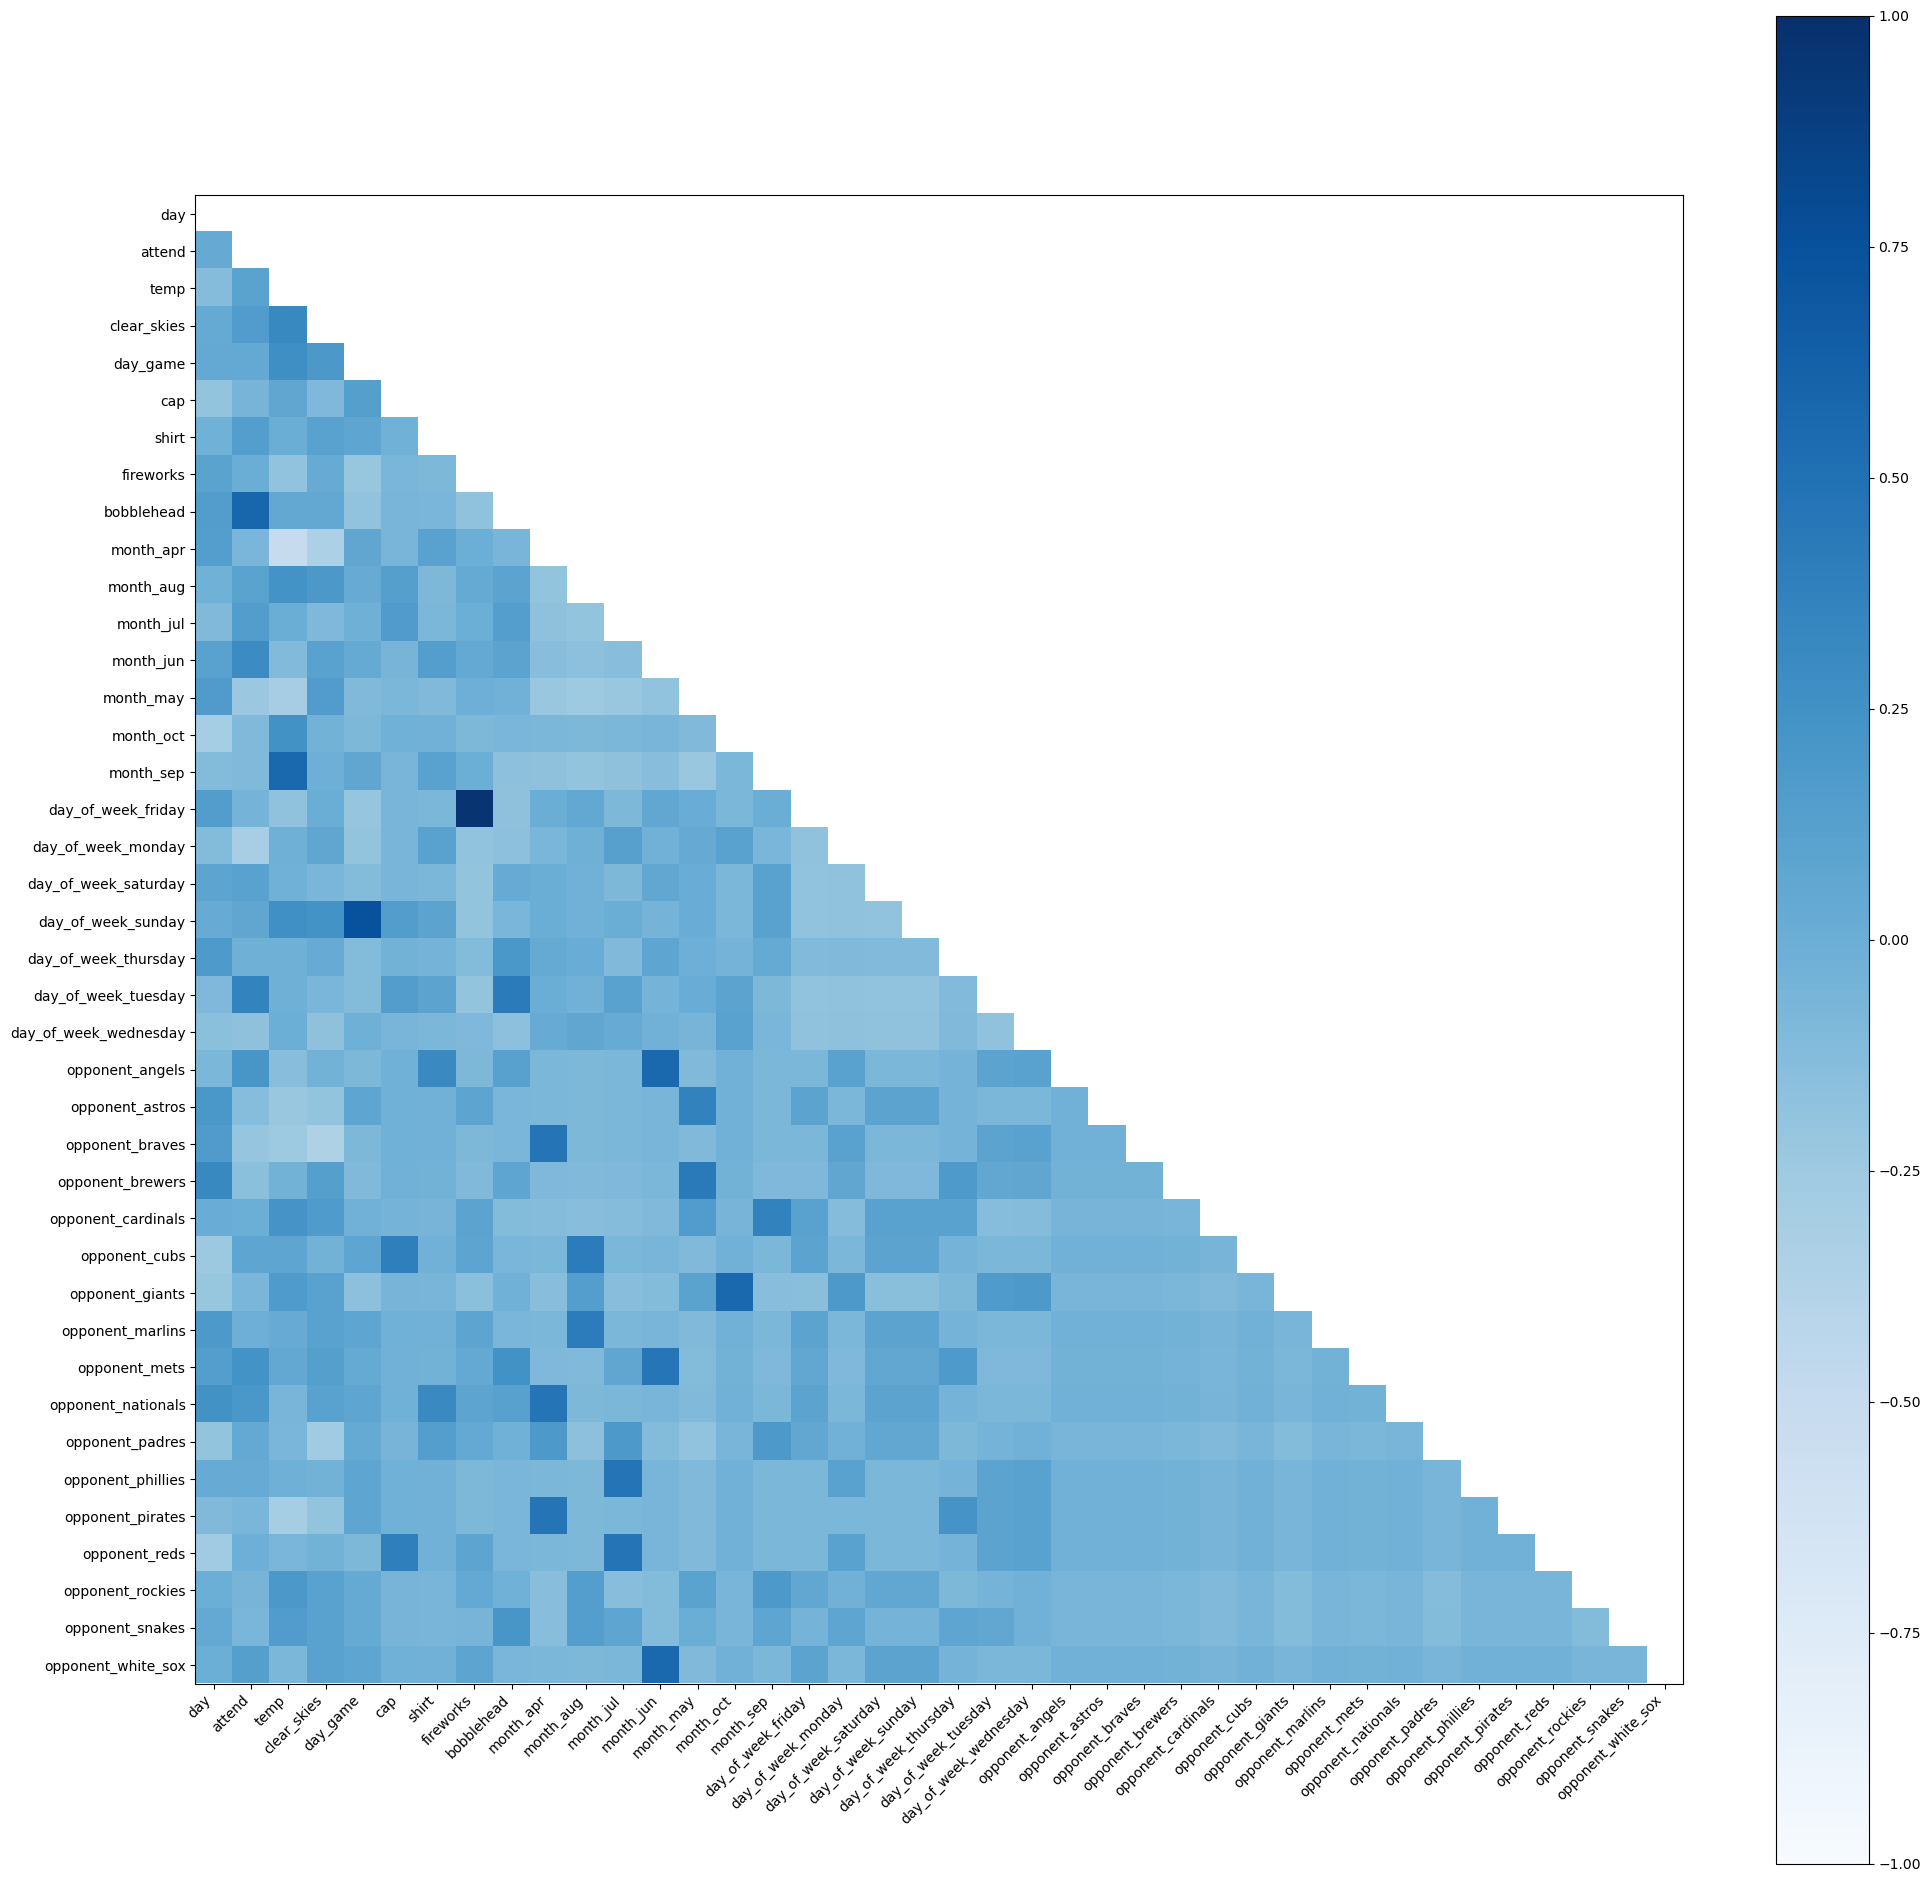

In [54]:
# Adapted from https://www.geeksforgeeks.org/create-a-correlation-matrix-using-python/
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from sklearn import datasets
import pandas as pd

matrix = with_dummies.corr()

# Mask the duplicated upper triangle and the diagonal
mask = np.triu(np.ones_like(matrix, dtype=bool))
masked_matrix = np.ma.masked_array(matrix, mask)

# plot the masked correlation matrix
plt.imshow(masked_matrix, vmin=-1, vmax=1, cmap="Blues")

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Make the figure full screen
plt.rcParams['figure.figsize'] = [24, 24]

# Display the plot
plt.show()

In [55]:
# Set a threshold for strong correlations
threshold = 0.5

# Iterate through the correlation matrix and filter based on the threshold
correlations = []
seen = {}
for column in matrix.columns:
    for index in matrix.index:
        seen_key = [column,index]
        seen_key.sort()
        seen_key = ''.join(seen_key)
        if seen_key in seen:
            continue
        else:
            seen[seen_key] = 1
        if index != column and abs(matrix.loc[index, column]) > threshold:
            correlation = matrix.loc[index, column]
            correlations.append({
                'correlation':correlation,
                'index':index,
                'column':column,
            })

cors = sorted(correlations, key=lambda d: d['correlation'])
for cor in cors:
    print("{:+.5f} {} -> {}".format(cor['correlation'],cor['index'],cor['column']))

-0.51200 month_apr -> temp
+0.55470 opponent_giants -> month_oct
+0.55470 opponent_angels -> month_jun
+0.55470 opponent_white_sox -> month_jun
+0.56011 month_sep -> temp
+0.58189 bobblehead -> attend
+0.74399 day_of_week_sunday -> day_game
+0.95651 day_of_week_friday -> fireworks


#### Analyze Correlations

There are some correlations here that are expected, such as the temperature correlating to the month. Other correlations show patterns in programming:

* Fireworks are generally done on Fridays
* Sundays are generally day games
* The dodgers played the giants in October and played the Angels and White Sox in Jun.

There is a critical correlation here that might provide an indication of how to improve attendance, which is the "bobblehead" condition. When the "bobblehead" is present, attendance tends to be higher. Whether this proves causation or is similar to programming decisions, such as having fireworks on Fridays, would require further analysis.

#### Attempt a Linear Regression Model

In [56]:
# Split the data into predictor data and target column
target_column = 'attend'
data = with_dummies.copy()
target = data[target_column]
data.drop([target_column], inplace=True, axis=1)

# Split the data into 80% training and 20% testing
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=42)

print("Training Data: ",data_train.shape, "Test data: ",data_test.shape)

Training Data:  (64, 39) Test data:  (17, 39)


In [57]:
def print_model_metrics(test,pred):
    mae = metrics.mean_absolute_error(test, pred)
    mse = metrics.mean_squared_error(test, pred)
    rmse = np.sqrt(mse) # or mse**(0.5)  
    r2 = metrics.r2_score(test, pred)
    
    print("R-Squared:", r2)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolue Error (MAE): ",mae)

# Build the model with the columns in a specific order, so that
# we can pair the columns with the coefficients for analysis later.
model_columns = data_train.columns
model = LinearRegression().fit(data_train[model_columns],target_train)
coefficients = list(zip(model_columns,model.coef_))

# Obtain the predictions
target_pred = model.predict(data_test)

print("LinearRegression Metrics:")
print_model_metrics(target_test,target_pred)

LinearRegression Metrics:
R-Squared: 0.12209095246024049
Root Mean Squared Error (RMSE): 9290.744150802151
Mean Absolue Error (MAE):  7386.547606778323


#### Coefficients

In [58]:
sorted_coef = sorted(coefficients, key=itemgetter(1))
for coef in sorted_coef:
    print(coef[0],coef[1])

day_of_week_friday -16118.29583293249
month_apr -11585.856321502955
cap -7589.533374940717
opponent_astros -6480.1799221782685
opponent_marlins -6315.423496325919
opponent_reds -3317.3756456068495
opponent_snakes -3130.913350932372
opponent_giants -3105.239462902717
month_may -2577.406525736656
day_of_week_monday -2437.162946142595
shirt -2353.8821784658508
opponent_rockies -1945.2329553281745
opponent_brewers -1928.98173640902
clear_skies -766.3445584847514
month_sep -375.4398870130925
opponent_white_sox -313.1509038970658
day_game -269.3709733047583
temp -181.81774654577
day_of_week_wednesday -167.0017138577736
day 69.02131415946556
opponent_pirates 160.24885651932175
day_of_week_thursday 307.90277894228194
opponent_mets 769.0588089288347
opponent_phillies 1128.1672731795445
opponent_cubs 1373.9951151149714
opponent_cardinals 1499.2565492629715
opponent_angels 1611.040269508187
month_jul 1688.4845466537483
opponent_braves 1848.4947800042069
opponent_padres 1921.6672560444722
day_of_w

#### Analysis of Linear Regression

There is so little data, that the use of a linear regression model is risky. And, as it turns out, the Linear Regression was not particularly successful. An R-Squared value of 0.12 means that very little of the variance in attendance can be explained by the linear model. Of the variance that was explained, Tuesday and Sunday games were more likely to increase attendance. Also, fireworks and bobblehead condition increased attendance. Lastly, having the Nationals as the opponent also increased attendance. However, based on the low r-squared value and the limited data, these insights should be used cautiously.

#### Conclusion

This analysis would benefit from significantly more data, encompasing more years and more teams. With what is available, however, the best single recommendation I could make to increase attendance would be to increase the occurence of the bobblehead condition. I need more domain knowledge on this characteristic to know how best to make use of this insight, or even if it applies. It could be that some other factor is independently driving both the use of the bobblehead and attendance. However, this is the variable that correlates most closely with attendance, so it is a good place to focus. It might also be worth considering playing more games against the Nationals to take advantage of the increased attendance that opponent appears to give. Lastly, it may be worth it to consider using fireworks more, but this would need to be weighed against the costs of adding additional fireworks displays.